# Notebook created by following the tinyML book example hello world

The original notebook create_sine_model.ipynb has been removed from the repository and replaced by 
_tflite-micro/tensorflow/lite/micro/examples/hello_hello_wordl/train.py._
Creating the TensorFlow model is done by simply running train.py. This produces the Tensorflow Lite model in /tmp/model_created 
under the name hello_world_float.tflite
Finally the program ptq.py in the subdirectory _quantization_ converts the model from float to int8 format, thus considerably recuding its size and stores it in /tmp/quant_model/hello_world_int8.tflite
In contrast to the method for model creation described in the TinyML book, the original sine data do not contain any noise and many problems that might arise like underfitting are not demonstracted nor any plots generated.
Using juypter notebook also allows to follow the steps slowly one by one.

In [1]:
# This will disable warnings from TensorFlow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#Tensorflow is the open source machine learning library
import tensorflow as tf
# numpy is a math library
import numpy as np
# mathplotlib is a graphing library
import matplotlib.pyplot as plt
# math is the Python mathematics library
import math

First we generate data points that will be used to train the model

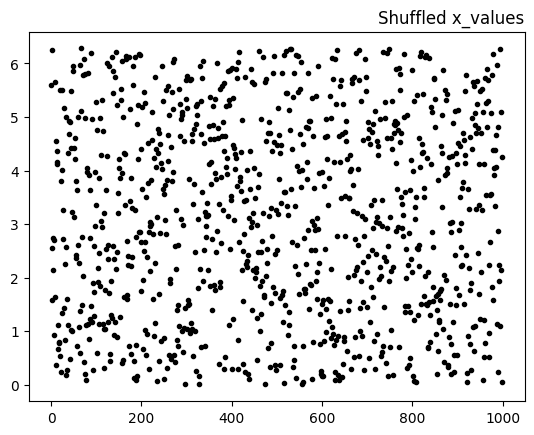

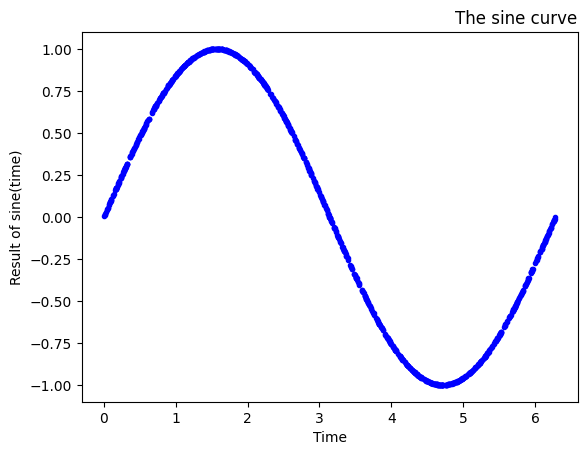

In [2]:
# We'll generate this many sample data points
SAMPLES=1000

# Set a "seed" value, so we get the same random numbers each time e run this notebook. 
# Any number can be used here.
SEED = 1337

np.random.seed(SEED)
tf.random.set_seed(SEED)

# Generate a uniformly distributed sset of random numbers in the range of 
# 0 to 2pi, which covers a complete sine wave oscillation
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)

# Shuffle the valuesmmto guarantee they are not in order
np.random.shuffle(x_values)

# Calculate the corresponding sin values
y_values = np.sin(x_values)

# Plot the X_values to prove they are nicely shuffled. The 'k.' argument means to use black dots.
plt.plot(x_values,'k.')
plt.title('Shuffled x_values',loc='right')
plt.show()

# Plot our data. The 'b,' argument tells the library to print blue dots.
plt.plot(x_values, y_values, 'b.')
plt.title("The sine curve",loc='right')
plt.xlabel('Time')
plt.ylabel('Result of sine(time)')
plt.show()

The nice thing about machine learning is that it can find pattern even in noisy data.
To demonstrate this we will add some random noise to the data.

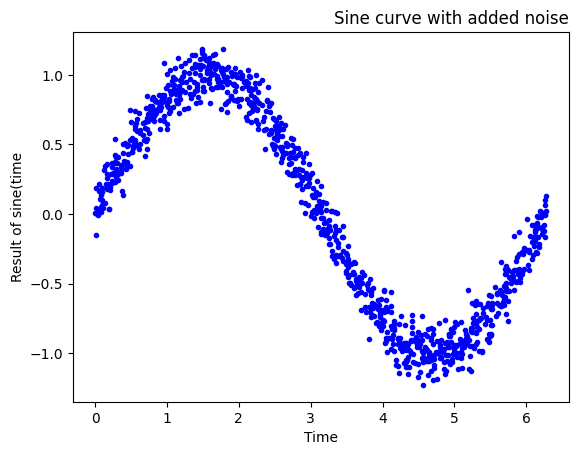

In [3]:
# Add a small number of random data to the y_values
y_values += 0.1*np.random.randn(*y_values.shape)

# Plot the new data
plt.plot(x_values,y_values,'b.')
plt.title('Sine curve with added noise',loc='right')
plt.ylabel('Result of sine(time')
plt.xlabel('Time')
plt.show()

## Splitting the data
In order to evaluate the accuracy of the model we split the data into a training set, a validation set and a test set

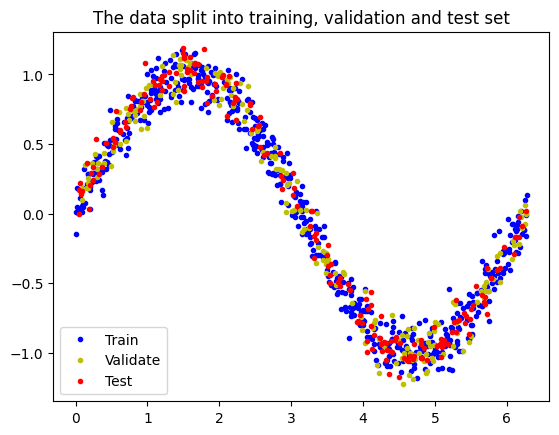

In [4]:
# We will use 60% of the data for training and 20% for testing
# The temeining 20% will be used for validation. Calculate the indices for each section
TRAIN_SPLIT = int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into the 3 parts
# The second parameter to np.split is an array of indices where the data will be split
# We provide two indices, so the data will be split into three chunks
x_train, x_validate, x_test = np.split(x_values, [TRAIN_SPLIT,TEST_SPLIT])
y_train, y_validate, y_test = np.split(y_values, [TRAIN_SPLIT,TEST_SPLIT])

# Double check that our splits end up correctly
assert (x_train.size + x_validate.size + x_test.size) == SAMPLES

# Plot the data in each partiction in different colors
plt.plot(x_train,y_train,'b.',label = 'Train')
plt.title('The data split into training, validation and test set')
plt.plot(x_validate,y_validate,'y.',label = 'Validate')
plt.plot(x_test,y_test,'r.',label = 'Test')
plt.legend(loc='lower left')
plt.show()

## Defining a basic model
Now that we have the data, it is time to define a basic model and we will train to fit it.
We will define a model that will take input values and output a number as an output value. This is a regression problem.

In [5]:
# Use keras to create a simple model architecture
from tensorflow.keras import layers
model_1 = tf.keras.Sequential()

# The first layer takes a scalar value and feeds it though 16 "neurons". The neurons decide wether to activate 
# based on the 'relu' activation function.
model_1.add(layers.Dense(16, activation='relu',input_shape=(1,)))

# The final layer is a single neuron since we want to output a single value
model_1.add(layers.Dense(1))

# Compile the model using a standard optimizer and loss function for regression
model_1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                32        
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 49 (196.00 Byte)
Trainable params: 49 (196.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


plot_model from keras.utils provides a nice graphical shape of the model

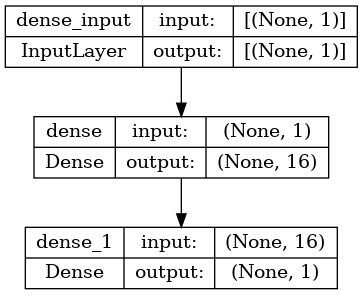

In [6]:
tf.keras.utils.plot_model(model_1,show_shapes=True)

In [7]:
def relu(input):
    return max(0.0,input)

<function matplotlib.pyplot.show(close=None, block=None)>

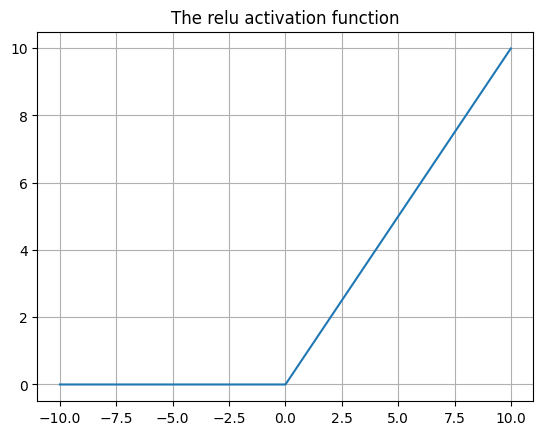

In [8]:
x_relu = []
y_relu = []
for i in range(-1000,1000):
    x_relu.append(i/100)
    y_relu.append(relu(i/100))
y_relu_values = np.asarray(y_relu)
y_relu_values = np.asarray(x_relu)

plt.plot(x_relu,y_relu)
plt.grid(visible=True)
plt.title("The relu activation function")
plt.show

# Train the model

In [9]:
history_1 = model_1.fit(x_train,y_train,epochs=1000,batch_size=16,validation_data=(x_validate,y_validate))

Epoch 1/1000
38/38 [==============================] - 1s 8ms/step - loss: 0.4141 - mae: 0.5460 - val_loss: 0.3934 - val_mae: 0.5433
Epoch 2/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.3527 - mae: 0.5157 - val_loss: 0.3563 - val_mae: 0.5102
Epoch 3/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.3173 - mae: 0.4887 - val_loss: 0.3212 - val_mae: 0.4888
Epoch 4/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.2883 - mae: 0.4668 - val_loss: 0.2900 - val_mae: 0.4623
Epoch 5/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.2630 - mae: 0.4482 - val_loss: 0.2630 - val_mae: 0.4399
Epoch 6/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.2398 - mae: 0.4286 - val_loss: 0.2441 - val_mae: 0.4228
Epoch 7/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.2229 - mae: 0.4131 - val_loss: 0.2305 - val_mae: 0.4132
Epoch 8/1000
38/38 [==============================] - 0s 3ms/step - loss: 0.

# Graphing the history

In [10]:
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

In [11]:
epochs = range(1,len(loss) +1)
epochs

range(1, 1001)

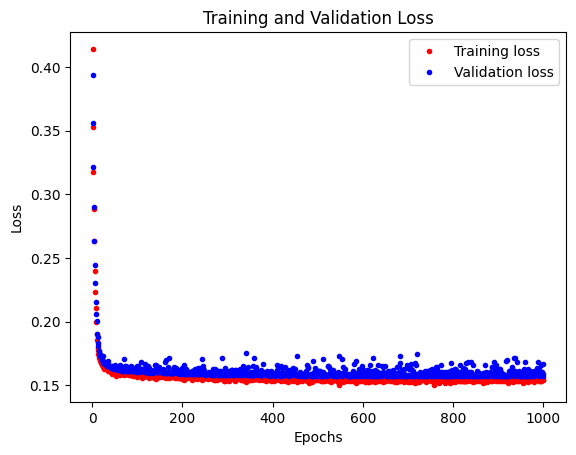

In [12]:
plt.plot(epochs, loss, 'r.', label='Training loss')
plt.plot(epochs, val_loss, 'b.', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
SKIP = 100

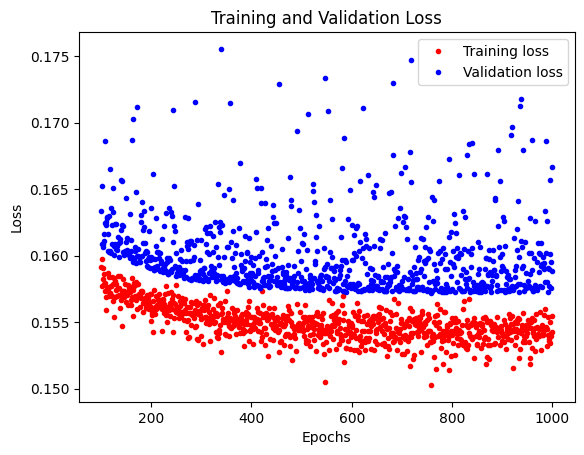

In [14]:
plt.plot(epochs[SKIP:], loss[SKIP:], 'r.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Remarks: 
* At around 600 epochs, training does not import improve losses any longer
* Lowest loss is around 0.15, which seems high
Now we plot the mean absolute error to get more insight into the model's performance

In [15]:
# Draw a graph of mean absolute error, which is another way of measuring the amount of error in the prediction
mae = history_1.history['mae']


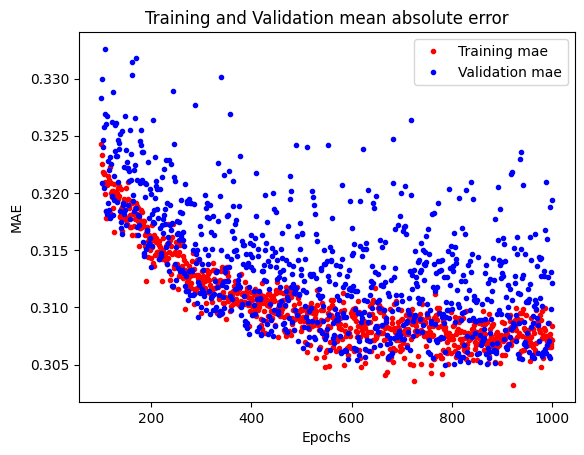

In [16]:
# Draw a graph of mean absolute error, which is another way of meaasuring the amount of error in the prediction
mae = history_1.history['mae']
val_mae = history_1.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'r.', label='Training mae')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation mae')
plt.title('Training and Validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

The mean absolute error values are around 0.31 which is very high as we expect sine values between -1 and 1.

Now let's try to plot the predictions along with the test data.

19/19 [==============================] - 0s 2ms/step


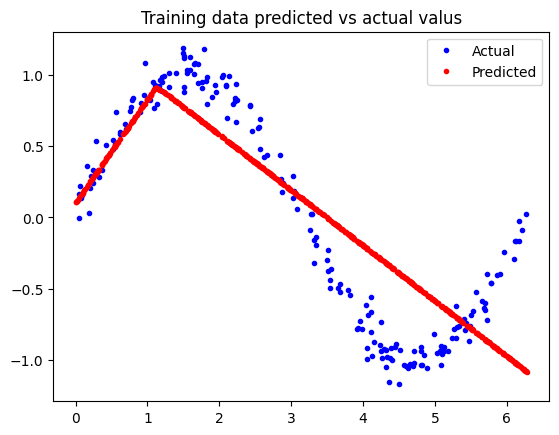

In [17]:
# use the model to make predictions from our training data
predictions = model_1.predict(x_train)

# Plot the predictions along with the test data
plt.clf()
plt.title('Training data predicted vs actual valus')
plt.plot(x_test,y_test,'b.',label='Actual')
plt.plot(x_train, predictions,'r.', label='Predicted')
plt.legend()
plt.show()

This clearly shows that the model is no good! The model is too small to represent the problem.
We will add another layer of neurons to allow it better learn the sine curve

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                32        
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


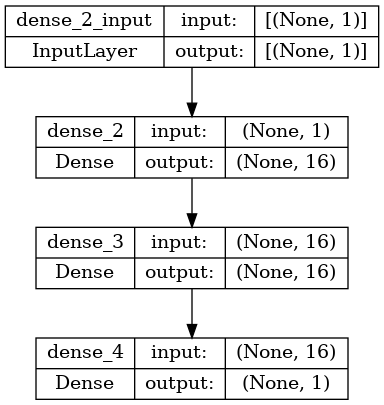

In [18]:
model_2 = tf.keras.Sequential()
# First layer takes a scalar input and feeds it through 116 neurons
model_2.add(layers.Dense(16,activation='relu',input_shape=(1,)))

# The new second layer may help the network learn more complex representations
model_2.add(layers.Dense(16,activation='relu'))

# The final layer is a single neuron, since we want to output aa single sine value
model_2.add(layers.Dense(1))

# Compile the model
model_2.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])

# Show the structure of the model
model_2.summary()
tf.keras.utils.plot_model(model_2,show_shapes=True)

While the old model only had 49 params, the new one has 321
Let's train the new model

In [19]:
history_2 = model_2.fit(x_train,y_train,epochs=600,batch_size=16,validation_data=(x_validate,y_validate))

Epoch 1/600
38/38 [==============================] - 1s 10ms/step - loss: 0.7706 - mae: 0.7408 - val_loss: 0.4729 - val_mae: 0.6037
Epoch 2/600
38/38 [==============================] - 0s 3ms/step - loss: 0.4056 - mae: 0.5538 - val_loss: 0.3936 - val_mae: 0.5341
Epoch 3/600
38/38 [==============================] - 0s 3ms/step - loss: 0.3332 - mae: 0.4993 - val_loss: 0.3210 - val_mae: 0.4886
Epoch 4/600
38/38 [==============================] - 0s 3ms/step - loss: 0.2787 - mae: 0.4577 - val_loss: 0.2695 - val_mae: 0.4454
Epoch 5/600
38/38 [==============================] - 0s 3ms/step - loss: 0.2355 - mae: 0.4237 - val_loss: 0.2244 - val_mae: 0.4053
Epoch 6/600
38/38 [==============================] - 0s 3ms/step - loss: 0.2021 - mae: 0.3921 - val_loss: 0.2048 - val_mae: 0.3805
Epoch 7/600
38/38 [==============================] - 0s 3ms/step - loss: 0.1834 - mae: 0.3713 - val_loss: 0.1875 - val_mae: 0.3698
Epoch 8/600
38/38 [==============================] - 0s 3ms/step - loss: 0.1702 - 

The loss has now dropped to 0.01, a major improvement!

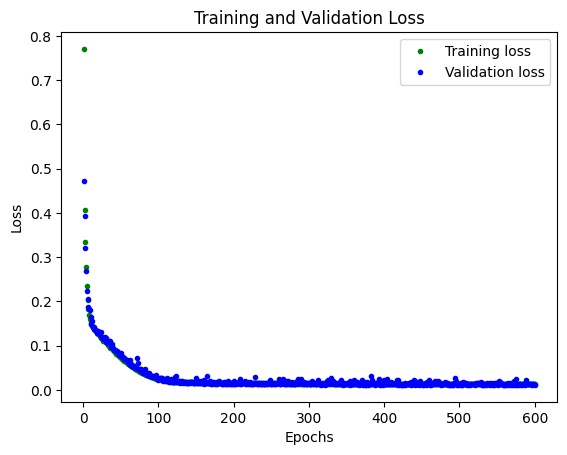

In [20]:
# Draw a graph of the loss, which is the distance between the predicted and the actual values
# during training and validation
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs= range(1,len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b.', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

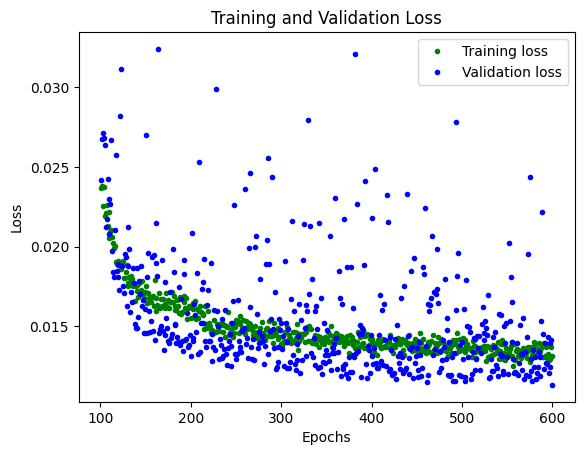

In [21]:
SKIP=100
plt.clf

plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

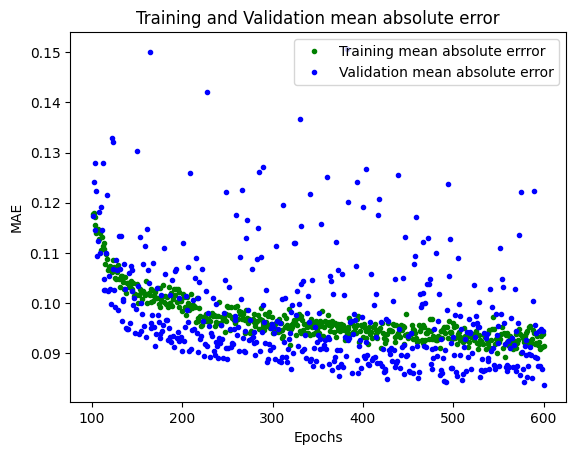

In [22]:
SKIP=100
plt.clf

# Draw a graph of mean absolute error, which is another way of
# measuring the amount of error in the prediction

mae = history_2.history['mae']
val_mae = history_2.history['val_mae']

plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training mean absolute errror')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation mean absolute error')
plt.title('Training and Validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

Make predictions with the new model and compare the predictions with the actual values

19/19 [==============================] - 0s 2ms/step


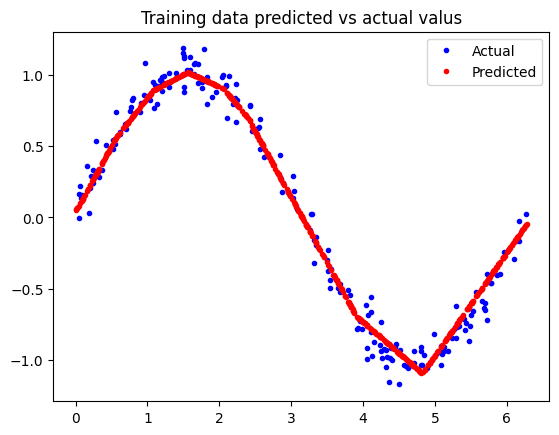

In [23]:
# use the model to make predictions from our training data
predictions = model_2.predict(x_train)

# Plot the predictions along with the test data
plt.clf()
plt.title('Training data predicted vs actual valus')
plt.plot(x_test,y_test,'b.',label='Actual')
plt.plot(x_train, predictions,'r.', label='Predicted')
plt.legend()
plt.show()

# Converting the model for tensorflow lite
Quantization allows to reduce the precision of the numbers in the model, which are stored as 32 bit floating point values to 8 bit integers
This may of course reduce the accuracy of the model but often the effect is rather small, such that it is almost always worthwhile

In [29]:
# Convert the model to Tensorflow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
tflite_model = converter.convert()
# Save the file to disk
f = open('models/tflite/sine_model.tflite','wb')
f.write(tflite_model)
f.close()

INFO:tensorflow:Assets written to: /tmp/tmpsa36bo20/assets


INFO:tensorflow:Assets written to: /tmp/tmpsa36bo20/assets


In [31]:
# Convert the model to Tensorflow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)
# Define a generator function that provides our test data's x values
# as representative dataset and tell the converter to use it
def representative_dataset_generator():
    for value in x_test:
        yield [np.array(value,dtype=np.float32, ndmin=2)]
        
# Indicate that we want default optimization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
converter.representative_dataset = representative_dataset_generator
# Convert the model
tflite_model = converter.convert()

# Save the model to disk
f = open("models/quantized/sine_model_quantized.tflite","wb")
f.write(tflite_model)
f.close()


INFO:tensorflow:Assets written to: /tmp/tmpp3ge44pm/assets


INFO:tensorflow:Assets written to: /tmp/tmpp3ge44pm/assets
/home/uli/.virtualenvs/AI/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8
